# • Probabilistic Forecast Evaluation

> Hierarchical Forecast's reconciliation and evaluation.

This notebook offers a step to step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `HierarchicalForecast` and `StatsForecast` core class, to create base predictions, reconcile and evaluate them. 

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline
1. Installing Packages
2. Prepare TourismL dataset
    - Read and aggregate
    - StatsForecast's Base Predictions
3. Reconciliar
4. Evaluar

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismLarge-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing HierarchicalForecast

We assume you have StatsForecast and HierarchicalForecast already installed, if not 
check this guide for instructions on how to install HierarchicalForecast.

In [ ]:
# %%capture
# !pip install hierarchicalforecast
# !pip install -U numba statsforecast datasetsforecast

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

from hierarchicalforecast.evaluation import scaled_crps
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.utils import HierarchicalPlot, CodeTimer

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

## 2. Preparing TourismL Dataset

### 2.1 Read Hierarchical Dataset

In [ ]:
# ['Labour', 'Traffic', 'TourismSmall', 'TourismLarge', 'Wiki2']
dataset = 'Labour'
verbose = True
intervals_method = 'permbu'
LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
with CodeTimer('Read and Parse data   ', verbose):
    print(f'{dataset}')
    if not os.path.exists('./data'):
        os.makedirs('./data')
    
    dataset_info = HierarchicalInfo[dataset]
    Y_df, S_df, tags = HierarchicalData.load(directory=f'./data/{dataset}', group=dataset)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    # Train/Test Splits
    Y_test_df = Y_df.groupby('unique_id').tail(dataset_info.horizon)
    Y_train_df = Y_df.drop(Y_test_df.index)
    Y_test_df = Y_test_df.set_index('unique_id')
    Y_train_df = Y_train_df.set_index('unique_id')

Labour
Code block 'Read and Parse data   ' took:	0.02564 seconds


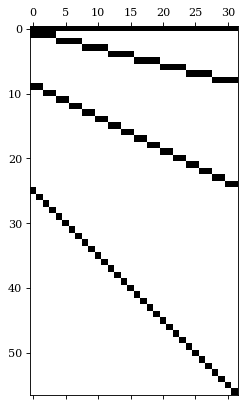

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [ ]:
Y_train_df

,ds,y
unique_id,,
['Total'],1978-02-01,5985.659716
['Total'],1978-03-01,6040.560795
['Total'],1978-04-01,6054.213859
['Total'],1978-05-01,6038.264751
['Total'],1978-06-01,6031.342299
...,...,...
"['Employed part-time', 'Males', 'Western Australia']",2018-12-01,117.524349
"['Employed part-time', 'Males', 'Western Australia']",2019-01-01,116.206500
"['Employed part-time', 'Males', 'Western Australia']",2019-02-01,118.041607


### 2.2 StatsForecast's Base Predictions

This cell computes the base predictions `Y_hat_df` for all the series in `Y_df` using StatsForecast's `AutoARIMA`.
Additionally we obtain insample predictions `Y_fitted_df` for the methods that require them.

In [ ]:
%%capture
with CodeTimer('Fit/Predict Model     ', verbose):
    # Read to avoid unnecesary AutoARIMA computation
    yhat_file = f'./data/{dataset}/Y_hat.csv'
    yfitted_file = f'./data/{dataset}/Y_fitted.csv'

    if os.path.exists(yhat_file):
        Y_hat_df = pd.read_csv(yhat_file)
        Y_fitted_df = pd.read_csv(yfitted_file)

        Y_hat_df = Y_hat_df.set_index('unique_id')
        Y_fitted_df = Y_fitted_df.set_index('unique_id')

    else:
        fcst = StatsForecast(
            df=Y_train_df, 
            models=[AutoARIMA(season_length=12)],
            fallback_model=[Naive()],
            freq='M', 
            n_jobs=-1
        )
        Y_hat_df = fcst.forecast(h=dataset_info.horizon, fitted=True, level=LEVEL)
        Y_fitted_df = fcst.forecast_fitted_values()
        Y_hat_df.to_csv(yhat_file)
        Y_fitted_df.to_csv(yfitted_file)

    # # # Matching Y_hat/S index ordering
    # Y_hat_df = Y_hat_df.reset_index()
    # Y_hat_df.unique_id = Y_hat_df.unique_id.astype('category')
    # Y_hat_df.unique_id = Y_hat_df.unique_id.cat.set_categories(S_df.index)
    # Y_hat_df = Y_hat_df.sort_values(by=['unique_id', 'ds'])
    # Y_hat_df = Y_hat_df.set_index('unique_id')

    # Y_fitted_df = Y_fitted_df.reset_index()
    # Y_fitted_df.unique_id = Y_fitted_df.unique_id.astype('category')
    # Y_fitted_df.unique_id = Y_fitted_df.unique_id.cat.set_categories(S_df.index)
    # Y_fitted_df = Y_fitted_df.sort_values(by=['unique_id', 'ds'])
    # Y_fitted_df = Y_fitted_df.set_index('unique_id')
    
    # S_df.index = pd.CategoricalIndex(S_df.index)

In [ ]:
Y_hat_df

,ds,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,AutoARIMA-lo-84,...,AutoARIMA-hi-80,AutoARIMA-hi-82,AutoARIMA-hi-84,AutoARIMA-hi-86,AutoARIMA-hi-88,AutoARIMA-hi-90,AutoARIMA-hi-92,AutoARIMA-hi-94,AutoARIMA-hi-96,AutoARIMA-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
['Australian Capital Territory'],2019-04-30,228.09427,223.61110,224.13643,224.46974,224.72047,224.92442,225.09802,225.25023,225.38652,...,230.56400,230.67809,230.80203,230.93831,231.09053,231.26411,231.46808,231.71881,232.05211,232.57745
['Australian Capital Territory'],2019-05-31,228.46031,223.14290,223.76599,224.16132,224.45871,224.70060,224.90651,225.08705,225.24869,...,231.38960,231.52492,231.67194,231.83357,232.01411,232.22000,232.46191,232.75931,233.15463,233.77773
['Australian Capital Territory'],2019-06-30,227.83786,221.77777,222.48788,222.93843,223.27736,223.55305,223.78770,223.99345,224.17767,...,231.17628,231.33050,231.49805,231.68227,231.88802,232.12268,232.39836,232.73729,233.18784,233.89795
['Australian Capital Territory'],2019-07-31,227.04823,220.24788,221.04474,221.55032,221.93065,222.24002,222.50334,222.73422,222.94095,...,230.79446,230.96751,231.15553,231.36226,231.59314,231.85646,232.16583,232.54616,233.05174,233.84860
['Australian Capital Territory'],2019-08-31,228.52385,221.08507,221.95674,222.50978,222.92583,223.26424,223.55228,223.80482,224.03096,...,232.62177,232.81108,233.01674,233.24287,233.49544,233.78348,234.12189,234.53792,235.09097,235.96263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
['Western Australia'],2019-07-31,1348.04700,1319.90380,1323.20150,1325.29400,1326.86790,1328.14820,1329.23790,1330.19350,1331.04900,...,1363.55070,1364.26680,1365.04490,1365.90050,1366.85600,1367.94570,1369.22610,1370.80000,1372.89230,1376.19020
['Western Australia'],2019-08-31,1353.71250,1322.63900,1326.28020,1328.59030,1330.32820,1331.74180,1332.94510,1334.00010,1334.94470,...,1370.83060,1371.62130,1372.48050,1373.42500,1374.48000,1375.68320,1377.09690,1378.83470,1381.14490,1384.78610
['Western Australia'],2019-09-30,1354.03360,1320.16400,1324.13280,1326.65090,1328.54520,1330.08590,1331.39750,1332.54740,1333.57700,...,1372.69190,1373.55380,1374.49020,1375.51990,1376.66980,1377.98120,1379.52210,1381.41640,1383.93440,1387.90320


In [ ]:
Y_fitted_df

,ds,y,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,...,AutoARIMA-hi-80,AutoARIMA-hi-82,AutoARIMA-hi-84,AutoARIMA-hi-86,AutoARIMA-hi-88,AutoARIMA-hi-90,AutoARIMA-hi-92,AutoARIMA-hi-94,AutoARIMA-hi-96,AutoARIMA-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
['Australian Capital Territory'],1978-02-01,94.88026,94.785380,90.30220,90.827530,91.160840,91.411575,91.615524,91.789120,91.941330,...,97.255100,97.369190,97.493130,97.629420,97.781630,97.955220,98.15918,98.409910,98.743220,99.268555
['Australian Capital Territory'],1978-03-01,95.17388,94.927460,90.44428,90.969610,91.302925,91.553660,91.757614,91.931206,92.083420,...,97.397180,97.511270,97.635216,97.771500,97.923710,98.097305,98.30126,98.551994,98.885300,99.410640
['Australian Capital Territory'],1978-04-01,93.79273,94.933250,90.45007,90.975400,91.308716,91.559450,91.763400,91.937000,92.089200,...,97.402970,97.517060,97.641010,97.777290,97.929504,98.103096,98.30705,98.557785,98.891090,99.416430
['Australian Capital Territory'],1978-05-01,96.68964,94.517240,90.03406,90.559395,90.892700,91.143440,91.347390,91.520990,91.673195,...,96.986950,97.101050,97.225000,97.361280,97.513490,97.687090,97.89104,98.141780,98.475080,99.000420
['Australian Capital Territory'],1978-06-01,95.26527,95.749115,91.26594,91.791270,92.124570,92.375310,92.579260,92.752860,92.905070,...,98.218834,98.332924,98.456870,98.593155,98.745370,98.918960,99.12292,99.373650,99.706955,100.232290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
['Western Australia'],2018-12-01,1347.17710,1358.847800,1341.68160,1343.693100,1344.969400,1345.929400,1346.710300,1347.375100,1347.957900,...,1368.304300,1368.741100,1369.215700,1369.737500,1370.320400,1370.985100,1371.76600,1372.726100,1374.002300,1376.013800
['Western Australia'],2019-01-01,1322.55260,1339.174400,1322.00830,1324.019800,1325.296000,1326.256100,1327.037100,1327.701800,1328.284500,...,1348.631000,1349.067900,1349.542500,1350.064300,1350.647100,1351.311800,1352.09280,1353.052900,1354.329000,1356.340600
['Western Australia'],2019-02-01,1340.27480,1334.714200,1317.54820,1319.559700,1320.835900,1321.796000,1322.576900,1323.241600,1323.824500,...,1344.170800,1344.607700,1345.082300,1345.604100,1346.186900,1346.851700,1347.63260,1348.592700,1349.868900,1351.880400


## 3. Reconciliate Predictions

In [ ]:
with CodeTimer('Reconcile Predictions ', verbose):
    reconcilers = [
        BottomUp(),
        MinTrace(method='ols'),
        #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
        ERM(method='closed')
    ]
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df,
                                Y_df=Y_fitted_df,
                                S=S_df, tags=tags,
                                level=LEVEL,
                                intervals_method=intervals_method)

Code block 'Reconcile Predictions ' took:	0.47703 seconds


## 4. Evaluation

In [ ]:
with CodeTimer('Evaluate Models       ', verbose):
    # Matching Y_test/Y_rec/S index ordering
    Y_test_df = Y_test_df.reset_index()
    Y_test_df.unique_id = Y_test_df.unique_id.astype('category')
    Y_test_df.unique_id = Y_test_df.unique_id.cat.set_categories(S_df.index)
    Y_test_df = Y_test_df.sort_values(by=['unique_id', 'ds'])

    Y_rec_df = Y_rec_df.reset_index()
    Y_rec_df.unique_id = Y_rec_df.unique_id.astype('category')
    Y_rec_df.unique_id = Y_rec_df.unique_id.cat.set_categories(S_df.index)
    Y_rec_df = Y_rec_df.sort_values(by=['unique_id', 'ds'])

    # Hardcoding model_names
    mintrace_ols_cols = [col for col in Y_rec_df.columns if 'AutoARIMA/MinTrace_method-ols-' in col]
    erm_closed_cols   = [col for col in Y_rec_df.columns if 'AutoARIMA/ERM_method-closed_lambda_reg-0.01-' in col]
    bottom_up_cols    = [col for col in Y_rec_df.columns if 'AutoARIMA/BottomUp-' in col]

    y_rec  = Y_rec_df[bottom_up_cols + erm_closed_cols + mintrace_ols_cols]
    model_columns = y_rec.columns

    n_series = len(S_df)
    y_rec  = y_rec.values.reshape(n_series, dataset_info.horizon, len(model_columns))
    y_test = Y_test_df['y'].values.reshape(-1, dataset_info.horizon)

    # Hardcoded evaluation
    models = {'AutoARIMA/BottomUp-': bottom_up_cols, 
                'AutoARIMA/ERM_method-closed_lambda_reg-0.01-': erm_closed_cols,
                'AutoARIMA/MinTrace_method-ols-': mintrace_ols_cols}

    results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                'Level': ['Overall'] + list(tags.keys()),
                'AutoARIMA/BottomUp-': [], 
                'AutoARIMA/ERM_method-closed_lambda_reg-0.01-': [],
                'AutoARIMA/MinTrace_method-ols-': []}

    for model in models:
        for level in results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(models[model])
            _y = y_test[row_idxs,:]
            _y_rec = y_rec[row_idxs,:,:][:,:,col_idxs]
            level_model_crps = scaled_crps(y=_y, y_hat=_y_rec,
                                            quantiles=QUANTILES)
            results[model].append(level_model_crps)
    results = pd.DataFrame(results)
results

Code block 'Evaluate Models       ' took:	0.05672 seconds


,Dataset,Level,AutoARIMA/BottomUp-,AutoARIMA/ERM_method-closed_lambda_reg-0.01-,AutoARIMA/MinTrace_method-ols-
0,Labour,Overall,0.006517,0.006511,0.006501
1,Labour,Country,0.013558,0.013560,0.013187
2,Labour,Country/Region,0.010885,0.010885,0.010885
3,Labour,Country/Gender/Region,0.010448,0.010448,0.010448
4,Labour,Country/Employment/Gender/Region,0.005294,0.005285,0.005275


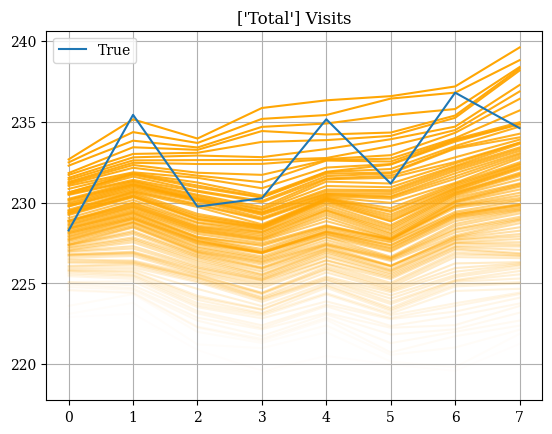

In [ ]:
# Qualitative evaluation, of parsed quantiles
row_idx = 0
col_idxs = model_columns.get_indexer(bottom_up_cols)
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[row_idx,:,col], color='orange', alpha=i/100)
plt.plot(y_test[row_idx,:], label='True')
plt.title(f'{S_df.index[row_idx]} Visits')

plt.legend()
plt.grid()
plt.show()
plt.close()

## References

- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
\"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022). 
"Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". 
Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)